## Analyzing Aggravated Burglaries in Davidson County

### Part 1 - Data Gathering using APIs

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2022. (Hint: Check out the API Docs (https://dev.socrata.com/foundry/data.nashville.gov/2u6v-ujjs) to see how to narrow down the response to just the desired results).

In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import json
from shapely.geometry import Point
import shapely
import numpy as np
from scipy.stats import poisson
from ipywidgets import interact, FloatSlider, IntSlider
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

Reading the API, I figured out I need the NIBRS code (https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes).
For burglary it is 220 and checking it on the webpage- It looks like this is what I'm looking for and the 'offense description' isn't always consistent. Will have to check which ones have 'aggravated' in there:
https://data.nashville.gov/resource/2u6v-ujjs.json?offense_nibrs=220

The code below just connects to the API and gets the requested type (burglary/breaking and entering)

In [2]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'

params = {
    '$where' : "incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'",
    'offense_nibrs' : 220,
    '$limit' : 5000
}

# you can also do a '$q' : 'BURGLARY- AGGRAVATED'

response = requests.get(endpoint, params = params)
response


<Response [200]>

In [3]:
# to check the constracted url with the params
response.url

'https://data.nashville.gov/resource/2u6v-ujjs.json?%24where=incident_reported+between+%272022-01-01T00%3A00%3A00%27+and+%272022-09-30T23%3A59%3A59%27&offense_nibrs=220&%24limit=5000'

In [4]:
len(response.json())

3532

In [5]:
incidents_df = pd.DataFrame(response.json())

In [6]:
# I used this before I figured out how to do it with regex
# incidents_df[incidents_df['offense_description'].str.upper().str.find('AGGRAVATED') != -1]

the below code is to get all the burglaries that contain at least agg (shorthand for AGGRAVATED). Comparing it to the output with my previous code I found out that the word AGGRAVATED was never actually abbreviated in the file

In [7]:
incidents_df = incidents_df[incidents_df['offense_description'].str.match(r'.+[aA][gG][gG].+') == True]

In [8]:
incidents_df['offense_description'].unique()

array(['BURGLARY- AGGRAVATED', 'BURGLARY - AGGRAVATED',
       'Burglary - Aggravated - Acting in Concert',
       'BURGLARY - ESPECIALLY AGGRAVATED',
       'BURGLARY - AGGRAVATED - ACTING IN CONCERT'], dtype=object)

2. Using the 2020 American Community Survey API (https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37.

First off, loading my key for the census data API!

In [9]:
with open('../keys.json') as fi:
    credentials = json.load(fi)

In [10]:
api_key = credentials['api_key']

> note: the documentation for how to construct the API request (for detailed tables) is found here: https://api.census.gov/data/2020/acs/acs5/examples.html

In [11]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:47&in=county:037&key={api_key}'


response = requests.get(endpoint)
response

<Response [200]>

In [12]:
pop_df = pd.DataFrame(response.json())

In [13]:
pop_df = (
    pop_df
    .rename(columns=pop_df.iloc[0])
    .drop(pop_df.index[0])
    .rename(columns={'B01001_001E':'population'})
)

Similar but different, Subject Tables now. 

In [14]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={api_key}'


response = requests.get(endpoint)
response

<Response [200]>

In [15]:
med_income_df = pd.DataFrame(response.json())

In [16]:
med_income_df = (
    med_income_df
    .rename(columns=med_income_df.iloc[0])
    .drop(med_income_df.index[0])
    .rename(columns={'S1901_C01_012E':'median_income'})
)

Did a .head() and .count() command to make sure both tables have the same length (as they should, 174); after the merge below the number was the same (as it of course should).

In [17]:
pop_med_income_df = pd.merge(pop_df, med_income_df, "inner", on=['NAME', 'state', 'county', 'tract'])

### Part 2 - Spatial Joining and Data Merging

3. Download the 2020 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred.

In [18]:
tract_geo = gpd.read_file('../data/tl_2020_47_tract/tl_2020_47_tract.shp')

In [19]:
tract_geo.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,175,925200,47175925200,9252,Census Tract 9252,G5020,S,227429512,1667739,+35.7438100,-085.4940227,"POLYGON ((-85.61516 35.76106, -85.61509 35.761..."
1,47,175,925000,47175925000,9250,Census Tract 9250,G5020,S,480712883,1225717,+35.6695378,-085.4220628,"POLYGON ((-85.60513 35.70854, -85.60511 35.708..."


In [20]:
# incidents_df.info
incidents_df.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'location_code', 'location_description',
       'offense_number', 'offense_nibrs', 'offense_description',
       'weapon_primary', 'weapon_description', 'victim_number',
       'domestic_related', 'victim_type', 'victim_description',
       'victim_gender', 'victim_race', 'victim_ethnicity',
       'victim_county_resident', 'mapped_location', 'rpa', 'zone', 'zip_code'],
      dtype='object')

Note: at first I tried to use the 'mapped_location' to turn it into a point. However, both doing a list comprehension like this:
> x['coordinates'] for x in incidents_df['mapped_location'])

or, expanding the dictionary first with 
> incidents_df.mapped_location.apply(pd.Series)['coordinates']

and then trying to unpack the remaining list with a lambda-function
> incidents_df['lnglat'].apply(lambda x: x[0])

none of it was working. The error was 'float' is not subsciptible. Michael helped me figure out that some rows had NaNs, which is what caused that error. So, the code commented below works.

In [21]:
# working code, have to do an if statement to skip nans
# incidents_df['lat'] = (
#     [x['coordinates'][0] 
#      if x is not np.nan 
#      else None 
#      for x in incidents_df['mapped_location']]    
#)

In [22]:
# note: we decided it was easier to drop duplicate incidents BEFORE doing the spatial merge
incidents_df = incidents_df.drop_duplicates(subset='incident_number')

In [23]:
incidents_df['geometry'] = gpd.points_from_xy(
    incidents_df['longitude'], incidents_df['latitude'])

In [24]:
incidents_geo = gpd.GeoDataFrame(incidents_df, crs = tract_geo.crs, geometry = incidents_df['geometry'])

In [25]:
# has to be a right join so that we keep all tracts even with no burglaries within
incidents_by_tract = gpd.sjoin(incidents_geo, tract_geo, how='right', predicate = 'within')

In [26]:
incidents_by_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2794 entries, 0 to 1700
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   index_left                   1258 non-null   float64 
 1   primary_key                  1258 non-null   object  
 2   incident_number              1258 non-null   object  
 3   report_type                  1258 non-null   object  
 4   report_type_description      1247 non-null   object  
 5   incident_status_code         1258 non-null   object  
 6   incident_status_description  1258 non-null   object  
 7   investigation_status         1258 non-null   object  
 8   incident_occurred            1258 non-null   object  
 9   incident_reported            1258 non-null   object  
 10  incident_location            1252 non-null   object  
 11  latitude                     1258 non-null   object  
 12  longitude                    1258 non-null   object  


4. Aggregate the data by census tract. Warning: each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents. Which census tract had the highest number of burglaries? Which census tract had the highest number of burglaries per 1000 residents? Note: Make sure that you keep all census tracts, not just those that have had a burglary.

> highest number of burglaries -> tract # 143; to answer the other question, see point 5. as we need to get the population in

In [31]:
# to get rid of duplicate incidents
incidents_by_tract = incidents_by_tract.drop_duplicates(subset='incident_number')

In [65]:
incidents_by_tract.groupby('TRACTCE')['incident_number'].count().nlargest(5)

TRACTCE
014300    41
016300    37
016000    30
014200    27
019003    22
Name: incident_number, dtype: int64

In [64]:
# better way to see it than above
incidents_by_tract.groupby('NAMELSAD')['incident_number'].count().nlargest(5)

NAMELSAD
Census Tract 143       41
Census Tract 163       37
Census Tract 160       30
Census Tract 142       27
Census Tract 190.03    22
Name: incident_number, dtype: int64

In [34]:
incidents_by_tract.columns

Index(['index_left', 'primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'location_code', 'location_description',
       'offense_number', 'offense_nibrs', 'offense_description',
       'weapon_primary', 'weapon_description', 'victim_number',
       'domestic_related', 'victim_type', 'victim_description',
       'victim_gender', 'victim_race', 'victim_ethnicity',
       'victim_county_resident', 'mapped_location', 'rpa', 'zone', 'zip_code',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [35]:
pop_med_income_df.columns

Index(['NAME', 'population', 'state', 'county', 'tract', 'median_income'], dtype='object')

In [36]:
incidents_by_tract_stats = pd.merge(
    pop_med_income_df, incidents_by_tract,
    how='inner', left_on='tract', right_on='TRACTCE'
)

5. Merge in the census data that you gathered in question 2. Remove any rows that have zero population or negative median income values.

In [37]:
# code below to get rid of zero population and negative med values
incidents_by_tract_stats = incidents_by_tract_stats[(incidents_by_tract_stats['population']).astype(int) > 0] 
incidents_by_tract_stats = incidents_by_tract_stats[(incidents_by_tract_stats['median_income']).astype(float) >= 0]

In [38]:
# new column to have number of incidents per each tract
incidents_by_tract_stats['n_incidents_tract'] = incidents_by_tract_stats.groupby('TRACTCE')['incident_number'].transform('count').to_frame()

In [39]:
# new column to have number of incidents per population
incidents_by_tract_stats['n_incidents_tract_pop'] = incidents_by_tract_stats['n_incidents_tract']/(incidents_by_tract_stats['population']).astype(float)

In [40]:
incidents_by_tract_stats.sort_values('n_incidents_tract_pop', ascending=False)

,NAME_x,population,state,county,tract,median_income,index_left,primary_key,incident_number,report_type,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,n_incidents_tract,n_incidents_tract_pop
629,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,2004.0,20220078262_23,20220078262,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
643,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,2081.0,20220082577_11,20220082577,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
623,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,566.0,20220287522_11,20220287522,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
624,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,1807.0,20220341304_11,20220341304,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
625,"Census Tract 143, Davidson County, Tennessee",1617,47,037,014300,40425,3329.0,20220481471_11,20220481471,D,...,Census Tract 143,G5020,S,1253575,0,+36.1611635,-086.8156898,"POLYGON ((-86.82255 36.15333, -86.82255 36.154...",41,0.025356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,"Census Tract 156.33, Davidson County, Tennessee",4704,47,037,015633,108883,2021.0,20220305187_11,20220305187,D,...,Census Tract 156.33,G5020,S,13138415,4907139,+36.1451761,-086.5766361,"POLYGON ((-86.61354 36.14412, -86.59675 36.156...",1,0.000213
392,"Census Tract 116, Davidson County, Tennessee",5158,47,037,011600,78520,568.0,20220270509_11,20220270509,S,...,Census Tract 116,G5020,S,8132311,329831,+36.1834916,-086.7119394,"POLYGON ((-86.72758 36.18825, -86.72737 36.188...",1,0.000194
1203,"Census Tract 188.01, Davidson County, Tennessee",5501,47,037,018801,96942,1633.0,20220293433_12,20220293433,D,...,Census Tract 188.01,G5020,S,8463283,0,+36.0609910,-086.7571310,"POLYGON ((-86.77516 36.05341, -86.77516 36.053...",1,0.000182
1106,"Census Tract 178, Davidson County, Tennessee",5929,47,037,017800,96098,472.0,20220060620_11,20220060620,D,...,Census Tract 178,G5020,S,4106211,0,+36.1121384,-086.7923247,"POLYGON ((-86.81208 36.10881, -86.81193 36.109...",1,0.000169


> same answer as before, the tract with most burglaries per population is 143, the second and third change

### Part 3 - Statistical Modeling

6. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. Start with some EDA to look at the relationship between median income and number of aggravated burglaries.

> note: as observed by Monica, we don't really need the incident number; and sice this part is just for the statistical modeling, I'll condense the table with just the needed information in the code below.

In [41]:
tract_aggr_burglary = (
    incidents_by_tract_stats
    .groupby(['TRACTCE', 'population', 'median_income'])
    ['incident_number']
    .count()
    .to_frame()
    .reset_index()
)

In [42]:
tract_aggr_burglary[['median_income', 'population']] = tract_aggr_burglary[['median_income', 'population']].astype(float)
tract_aggr_burglary['burglary_per_1kpop'] = tract_aggr_burglary['incident_number'] * 1000 /tract_aggr_burglary['population']

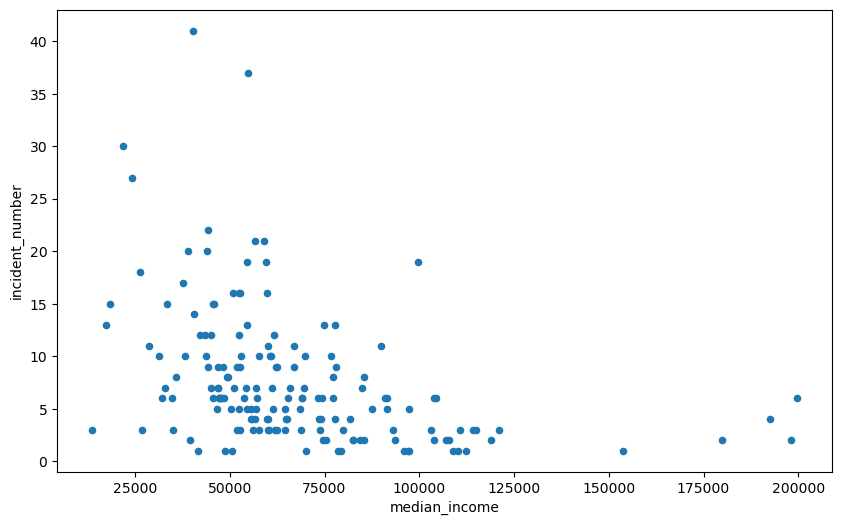

In [43]:
tract_aggr_burglary.plot(
    kind='scatter',
    x='median_income',
    y='incident_number',
    figsize = (10,6));

There appears to be a downward trend. I.e. with higher median income, there appears to be less aggravated burglaries.

In [44]:
ta_summary = (
    tract_aggr_burglary
    .assign(group = pd.qcut(tract_aggr_burglary['median_income'],
                            q = 10,
                           duplicates = 'drop'))
    .groupby('group')
    [['median_income', 'incident_number', 'burglary_per_1kpop']]
    .mean()
    .reset_index()
)

ta_summary

,group,median_income,incident_number,burglary_per_1kpop
0,"(13749.999, 38459.7]",28729.058824,11.882353,4.043676
1,"(38459.7, 46346.4]",43134.312500,13.625000,4.527355
2,"(46346.4, 50846.8]",48095.500000,6.000000,1.385436
3,"(50846.8, 55007.2]",52958.882353,11.352941,3.225753
4,"(55007.2, 60072.0]",57575.875000,8.500000,2.467688
5,"(60072.0, 65255.6]",62190.125000,6.312500,1.717109
6,"(65255.6, 74506.6]",70221.000000,5.647059,1.646089
7,"(74506.6, 85018.2]",79269.937500,5.437500,1.147417
8,"(85018.2, 103952.6]",93935.875000,5.000000,1.177264
9,"(103952.6, 199643.0]",132863.529412,2.823529,0.759494


Similar trends observed as described above

7. Fit a Poisson regression model with target variable the rate of burglaries per census tract and with predictor the median income. Offset using the log of the population so that we are looking at the rate of burglaries per population instead of the number of burglaries. How can you interpret the meaning of the output?

In [45]:
pr_burglary = smf.glm('incident_number ~ I(median_income/1000)',
                 data = tract_aggr_burglary,
                 offset = np.log(tract_aggr_burglary['population']/1000),
                 family = sm.families.Poisson()
                 ).fit()

pr_burglary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  164
Model:                            GLM   Df Residuals:                      162
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -663.57
Date:                Thu, 10 Nov 2022   Deviance:                       737.70
Time:                        21:07:30   Pearson chi2:                 1.15e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7265
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.7372      0.081     21.345      0.000       1.578       1.897
I(median_income / 1000)    -0.0179      0.001    -13.315      0.000      -0.021      -0.015
===========================================================================================
"""

After offsetting for population, and deciding to divide the median income by 1000 (otherwise the factor of changing by a single $ is miniscule) the model estimates that:

$$\text{average number of burglaries} = e^{-5.1513 -0.0187(\text{median income in thousands of UDS)}}$$

In other words, for each $1000 change in median income, the average number of burglaries is predicted to decrease by exp(-0.0187), aka a factor of 0.98147

In [46]:
# using the summary from before (the one with quantiles) to check how good the fit does
ta_summary['fitted'] = pr_burglary.predict(ta_summary)

ta_summary

,group,median_income,incident_number,burglary_per_1kpop,fitted
0,"(13749.999, 38459.7]",28729.058824,11.882353,4.043676,3.398180
1,"(38459.7, 46346.4]",43134.312500,13.625000,4.527355,2.626234
2,"(46346.4, 50846.8]",48095.500000,6.000000,1.385436,2.403204
3,"(50846.8, 55007.2]",52958.882353,11.352941,3.225753,2.202964
4,"(55007.2, 60072.0]",57575.875000,8.500000,2.467688,2.028330
5,"(60072.0, 65255.6]",62190.125000,6.312500,1.717109,1.867631
6,"(65255.6, 74506.6]",70221.000000,5.647059,1.646089,1.617707
7,"(74506.6, 85018.2]",79269.937500,5.437500,1.147417,1.375941
8,"(85018.2, 103952.6]",93935.875000,5.000000,1.177264,1.058429
9,"(103952.6, 199643.0]",132863.529412,2.823529,0.759494,0.527518


**note**: the fitted quantity has to be compared with burglary per capita (also same for the graph below). That is because we **offset** for population in our fit!!!

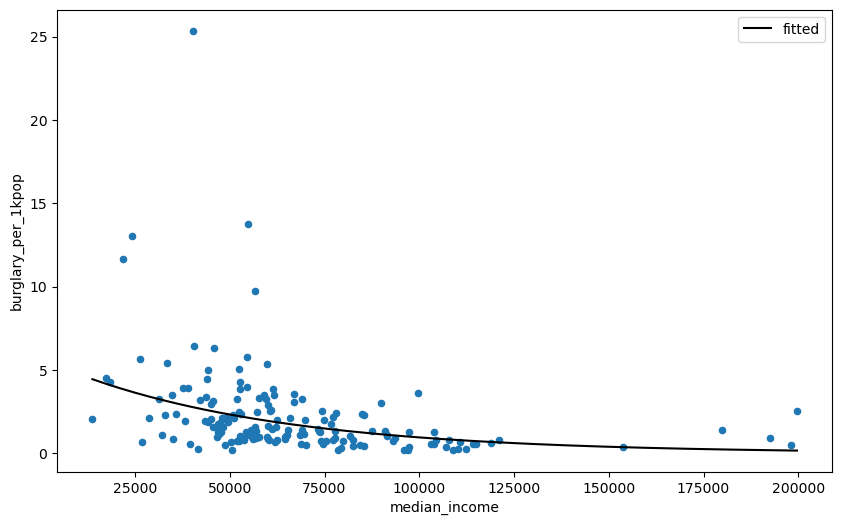

In [47]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(start = tract_aggr_burglary['median_income'].min(),
                      stop = tract_aggr_burglary['median_income'].max(),
                      num = 150)
})
fit_df['fitted'] = pr_burglary.predict(fit_df)

ax = tract_aggr_burglary.plot(x = 'median_income', y = 'burglary_per_1kpop', kind = 'scatter', figsize = (10,6))
fit_df.plot(x = 'median_income', y = 'fitted', color = 'black', ax = ax);

After checking the probabilities in the graph below, I decided to adjust the parameters and have the probabilities be estimated per 1000 people (otherwise the graph is far too squished towards 0).

In [48]:
@interact(median_income = IntSlider(value = 100000, min = tract_aggr_burglary['median_income'].min(), max = tract_aggr_burglary['median_income'].max()))
def fit_plot(median_income):
    
    mu = np.exp(pr_burglary.params['Intercept'] + \
                (median_income/1000) * pr_burglary.params['I(median_income / 1000)'])
    x = np.arange(start = 0, stop = 20, step = 1)
    y = poisson.pmf(x, mu = mu)

    plt.figure(figsize = (10,5))
    plt.bar(x, y, edgecolor = 'black')
    plt.xticks(x)
    plt.xlabel('Number of Burglaries per 1000 people')
    plt.ylabel('Probability')
    plt.title(f'Estimated Distribution of Number of Burglaries per 1000 people\nmedian_income = {median_income} \n$\mu$={round(mu, 3)}');

interactive(children=(IntSlider(value=100000, description='median_income', max=199643, min=13750), Output()), …

8. Bonus: Try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial (https://timeseriesreasoning.com/contents/negative-binomial-regression-model/). How does this model compare to the Poisson model?

In [49]:
# randomly split the data in 80% for training, 20% for test
mask = np.random.rand(len(tract_aggr_burglary)) < 0.8
df_train = tract_aggr_burglary[mask]
df_test = tract_aggr_burglary[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=124
Testing data set length=40


In [50]:
# slm expression, not sure how to incorporate the offset
expr = '''incident_number ~ I(median_income/1000)'''

In [51]:
# set up matrices for training dataset
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [52]:
# train poisson on train dataset
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [53]:
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  124
Model:                            GLM   Df Residuals:                      122
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -430.89
Date:                Thu, 10 Nov 2022   Deviance:                       402.16
Time:                        21:07:30   Pearson chi2:                     484.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6886
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.0154      0.084     36.067      0.000       2.852       3.179
I(median_income / 1000)    -0.0154      0.001    -10.763      0.000      -0.018      -0.013
===========================================================================================
"""

In [54]:
# this is the rate vector obtained from fitting
# poisson_training_results.mu
# len(poisson_training_results.mu)

In [55]:
# get the lambda values of the fit
df_train['incident_lambda'] = poisson_training_results.mu

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_39001/201252471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['incident_lambda'] = poisson_training_results.mu


In [56]:
# dependant variable of the OLS regression
df_train['aux_ols_dep'] = (
    df_train
    .apply(lambda x: ((x['incident_number'] - x['incident_lambda'])**2
                      - x['incident_lambda']) / x['incident_lambda'], axis=1)
)

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_39001/1621990215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['aux_ols_dep'] = (


In [57]:
# using patsy to form model specification
ols_expr = '''aux_ols_dep ~ incident_lambda - 1'''

#configure OSLR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [58]:
# this is the alpha that we were seeking (because the default is 1)
# and we wanted to get a better estimate for negative binomial
aux_olsr_results.params

incident_lambda    0.352603
dtype: float64

In [59]:
# this would be to check if the value of lamda is statistically significant
# with a t-value calculator
aux_olsr_results.tvalues

incident_lambda    3.034741
dtype: float64

In [60]:
# use the value of alpha calculated before (default is 1) on the neg binomial
nb2_training_results = (
    sm.GLM(y_train,
           X_train,
           family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
)

In [61]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  124
Model:                            GLM   Df Residuals:                      122
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -358.52
Date:                Thu, 10 Nov 2022   Deviance:                       100.77
Time:                        21:07:30   Pearson chi2:                     125.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2501
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.8608      0.155     18.482      0.000       2.557       3.164
I(median_income / 1000)    -0.0128      0.002     -5.493      0.000      -0.017      -0.008
===========================================================================================
"""

### Try predictions now!

In [62]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

In [63]:
predictions_summary_frame = nb2_predictions.summary_frame()
predictions_summary_frame)

SyntaxError: unmatched ')' (3943083609.py, line 2)

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['incident_number']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

Additional Resources for Generalized Linear Models:

- DataCamp - Generalized Linear Models in Python (https://learn.datacamp.com/courses/generalized-linear-models-in-python)
- Beyond Multiple Linear Regression, Chapter 4 (https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
- This set of notes (https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.